In [1]:
!pip install -r requirements.txt

In [1]:
from src.intelligent_placer_lib import load_objects, check_image
import cv2 as cv
import matplotlib.pyplot as plt


## Тестовый запуск

Фуyкция check_image имеет один обязательный параметр:
- "image: Исходное изображение с полигоном и предметами.

И два необязательных парааметра:
- "is_fitted": если True, то алгоритм будет использовать созданные заранее json файлы для каждого из изображений в директории по пути "objects_path;
- "objects_path": указывает на местоположение объектов, которые необходимо распознавать. 

Рассмотрим изображение, для которого будем проводить запуск (ниже)
На нём изображена прямоугольная красная карточка и деревянный магнит с кривыми границами
Они могут разместится внутри нарисованной фигуры, если будут уложены горизонтально одна под одной в левой части полигона


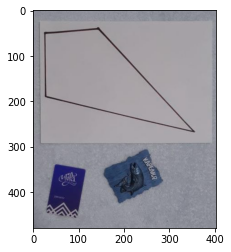

In [5]:
objects_path = "data/objects/"
dataset_path = "data/dataset/"
test_image_path = f"{dataset_path}30_y.jpg"
test_image = cv.imread(test_image_path)
plt.imshow(test_image)

Запустим алгоритм с обучением: is_fitted=False, objects_path="data/objects/" (по умолчанию соответствует структуре репозитория)

Если алгоритм начал обучатся, он логгирует соответствующие сообщения

Далее, алгоритм логгирует результат сопоставления предмета с его копией в композиции
Matches - число особых точек, совпавших между изображениями

Process objects
Did not found object: [id: 8, state: True] at scene. Mathces: 4
Did not found object: [id: 6, state: True] at scene. Mathces: 0
Did not found object: [id: 10, state: True] at scene. Mathces: 7
Found object: [id: 1, state: True] at scene. Mathces: 56
Did not found object: [id: 7, state: True] at scene. Mathces: 2
Did not found object: [id: 2, state: True] at scene. Mathces: 2
Found object: [id: 3, state: True] at scene. Mathces: 38
Did not found object: [id: 9, state: True] at scene. Mathces: 2
Did not found object: [id: 4, state: True] at scene. Mathces: 5
Did not found object: [id: 5, state: True] at scene. Mathces: 4
obj: 1, state: True, already placed: []
obj: 3, state: True, already placed: ['[id: 1, state: True]']
Check image: True
Real answer: True


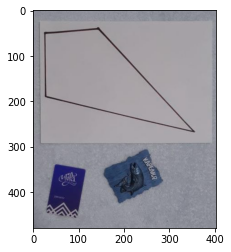

In [30]:
input_1 ={
    "image": test_image_path,
    "is_fitted": False,
    "objects_path": "data/objects/"
}

print(f"Check image: {check_image(**input_1)}")
print(f"Real answer: {test_image_path.split('_')[-1][0] == 'y'}")
plt.imshow(test_image)

## Описание процесса "обучения"
Изначально алгоритм тратит значительное время на предобработку всех предметов в папке objects
Что именно происходит:
- Алгоритм считывает все jpg файлы из директории;
- Для каждого изображения находится его описывающий контур;
- Для каждого изображения находятся его особые точки.

Промежуточные результаты сохраняются в директории objects в соответствующих поддиректориях:
- key_points: для каждого изображения сохраняется файл, на котором изображены особые точки предмета
- fitted: изображение сконтуром и особыми точками

## Примеры "обучения"
Рассмотрим, как выглядят некоторые примеры изображений до и после обработки
### Красная карточка (хороший предмет)
Красная карточка это хороший предмет для данного алгоритма. В этом мы убедимся далее, в разделе "Метрики"
Однако при текущей реализации даже с этим предметом возникают некоторые трудности. А именно, горы, изображённые белыми линиями внизу карты сливаются с листом бумаги и иногда они "обрезают" контур карты по верхней части этой белой линии. При текущих параметрах детектора контура это проявляется в неточной нижней границе

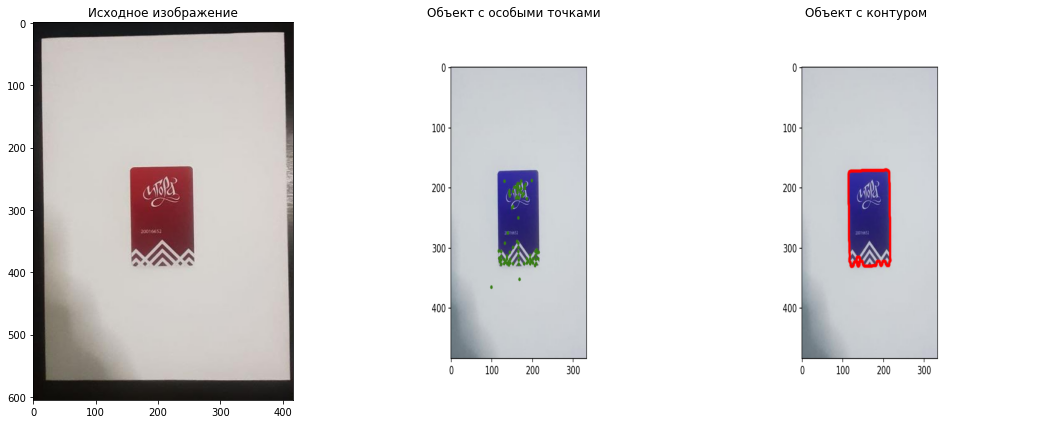

In [39]:
from imageio import imread, imsave
def show_fitted_object(obj_name):
    fig, ax = plt.subplots(1, 3, figsize=(15, 6))
    ax[0].imshow(imread(objects_path + obj_name + '.jpg'))
    ax[0].set_title('Исходное изображение')

    ax[1].imshow(imread(f"{objects_path}key_points/{obj_name}.png"), aspect='auto')
    ax[1].set_title('Объект с особыми точками')
    ax[1].set_axis_off()

    ax[2].imshow(imread(f"{objects_path}fitted/{obj_name}.png"), aspect='auto')
    ax[2].set_title('Объект с контуром')
    ax[2].set_axis_off()

    plt.tight_layout()
    
show_fitted_object('1')

### Ножницы (плохой предмет)
Ножницы плохи по двум причинам:
- Лезвие ножниц меняет свой вид в зависимости от падения света. Это порождает лишние особые точки. Кроме этого, лезвие имеет серебристый цвет, который сливается с белым фоном при определенной освещенности;
- Ножницы имеют сложный контур

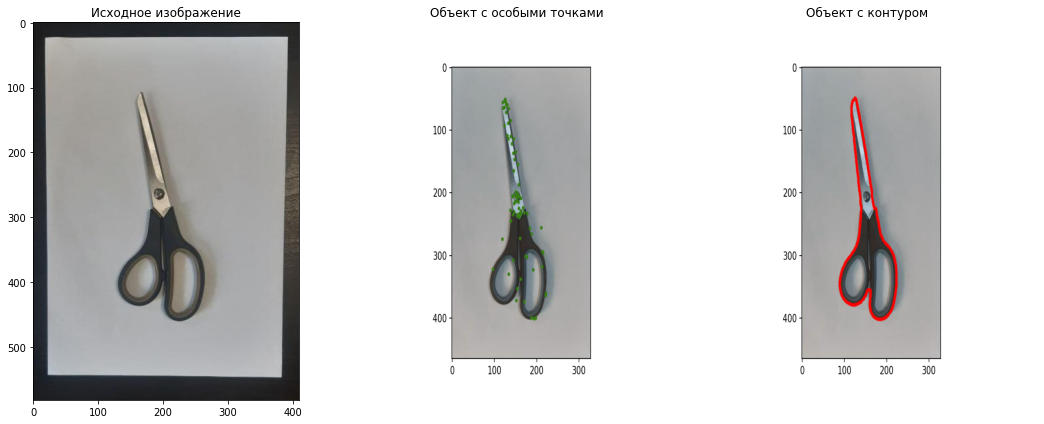

In [40]:
show_fitted_object('8')

### Маркер (специфический предмет)
С одной стороны, контур маркера прост и легко находится. С другой стороны текущая конфигурация алгоритма поиска особых точек находит их крайне мало на маркере. Это затрудняет его нахождение в композиции

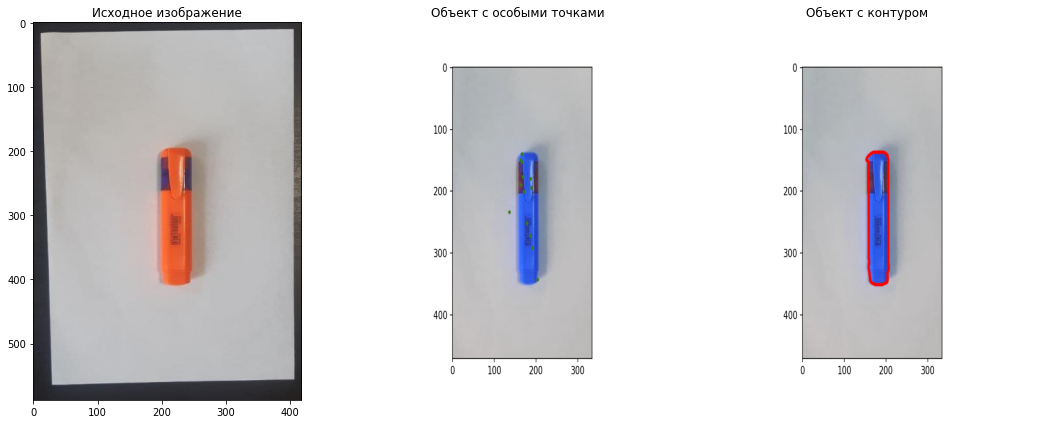

In [41]:
show_fitted_object('9')

## Детальный разбор тестового запуска

Рассмотрим по шагам, что и как делает алгоритм для тестового изображения (см в начало)
Рассмотрим работу алгоритма в случае, когда данные уже обработаны

Изначально из указанной директории выгружаются все объекты. Для каждого найденного изображения ищется json с соответствующим названием, а далее по ним создаются объекты класса Object(см readme)

### Загрузка объектов

In [46]:
# Загрузка объектов по их json конфигурациям
objects = load_objects(objects_path)

print(f"Тип созданных объектов: {type(objects[0])})")
print(f"Строковое представление: {objects[0]}")
json_obj =  objects[0].to_dict()
json_obj['contour'] = json_obj['contour'][1:6]
print(f"JSON-представление: {json_obj}")

Тип созданных объектов: <class 'src.intelligent_placer_lib.object.Object'>)
Строковое представление: [id: 8, state: True]
JSON-представление: {'id': '8', 'contour': [[[124, 51]], [[123, 52]], [[121, 52]], [[120, 53]], [[120, 54]]], 'kp_count': 80}


### Создание сцены

После этого созадётся объект класса Scene по изображению, поданному на вход

При создании этого класса происходит обработка исходного изображение: оно разбивается на многоугольник(объект класса Polygon) и на множество загруженных объектов из прошлой секции
При инициализации все объекты, поданные на вход в конструктор, проверяются на совпадение с одним из объектов на исходном изображении. Те, которые были найдены, сохранятся

Did not found object: [id: 8, state: True] at scene. Mathces: 3
Did not found object: [id: 6, state: True] at scene. Mathces: 0
Did not found object: [id: 10, state: True] at scene. Mathces: 7
Found object: [id: 1, state: True] at scene. Mathces: 56
Did not found object: [id: 7, state: True] at scene. Mathces: 2
Did not found object: [id: 2, state: True] at scene. Mathces: 2
Found object: [id: 3, state: True] at scene. Mathces: 37
Did not found object: [id: 9, state: True] at scene. Mathces: 2
Did not found object: [id: 4, state: True] at scene. Mathces: 5
Did not found object: [id: 5, state: True] at scene. Mathces: 5


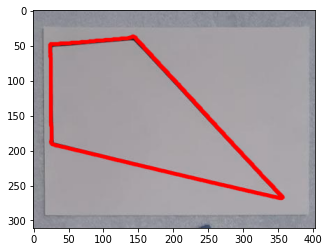

In [64]:
from src.intelligent_placer_lib.scene import Scene
img = cv.imread(test_image_path)
test_scene = Scene(img, objects, objects_path)

По логам видно, что на изображении были найдены 2 объекта из всех: 1 и 3. В таком случае, должно было сохранится изображение совпадений для каждого из них

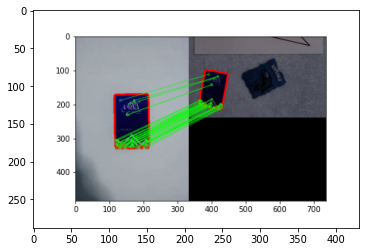

In [55]:
scene_image_1 = imread(f"{objects_path}matches/1.png")
plt.imshow(scene_image_1)

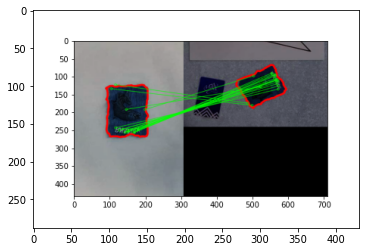

In [56]:
scene_image_2 = imread(f"{objects_path}matches/3.png")
plt.imshow(scene_image_2)

Алгоритм сумел точно распознать данные предметы в композиции и точно отобразил контуры с эталонного изображения на поданное на вход

### Малый фейл распознавания

Расческа является трудным предметом для алгоритма соспоставления, т.к. её особые точки могут находится на различных зубцах. Это приводит к неверной трансформации контура, как показано ниже

Did not found object: [id: 8, state: True] at scene. Mathces: 4
Did not found object: [id: 6, state: True] at scene. Mathces: 4
Did not found object: [id: 1, state: True] at scene. Mathces: 8
Did not found object: [id: 7, state: True] at scene. Mathces: 0
Did not found object: [id: 2, state: True] at scene. Mathces: 2
Did not found object: [id: 3, state: True] at scene. Mathces: 10
Did not found object: [id: 9, state: True] at scene. Mathces: 3
Did not found object: [id: 4, state: True] at scene. Mathces: 8
Found object: [id: 5, state: True] at scene. Mathces: 18


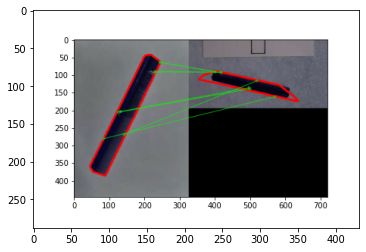

In [61]:
objects = load_objects(objects_path)
scene = Scene(cv.imread(dataset_path+'28_n.jpg'), objects, objects_path)
scene_image_3 = imread(f"{objects_path}matches/5.png")
plt.imshow(scene_image_3)

### Значительный фейл распознавания

Таких, к сожалению, не мало на данный момент

Did not found object: [id: 8, state: True] at scene. Mathces: 8
Did not found object: [id: 6, state: True] at scene. Mathces: 6
Did not found object: [id: 10, state: True] at scene. Mathces: 5
Did not found object: [id: 1, state: True] at scene. Mathces: 2
Did not found object: [id: 7, state: True] at scene. Mathces: 2
Did not found object: [id: 2, state: True] at scene. Mathces: 0
Did not found object: [id: 3, state: True] at scene. Mathces: 17
Did not found object: [id: 9, state: True] at scene. Mathces: 5
Found object: [id: 4, state: True] at scene. Mathces: 12
Found object: [id: 5, state: True] at scene. Mathces: 12


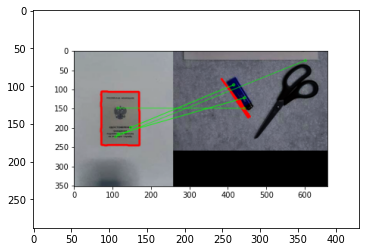

In [63]:
objects = load_objects(objects_path)
scene = Scene(cv.imread(dataset_path+'25_y.jpg'), objects, objects_path)
scene_image_4 = imread(f"{objects_path}matches/4.png")
plt.imshow(scene_image_4)

### Укладка объектов в полигон

В конце алгоритм пытается уложить все объекты внутрь полигона. На данный момент это простое сравнение суммарной площади всех объектов с плоащдью полигона

In [66]:
print(f"Удалось ли поместить объекты в полигон: {test_scene.place_objects()}")

obj: 1, state: True, already placed: ['[id: 1, state: True]', '[id: 3, state: True]']
obj: 3, state: True, already placed: ['[id: 1, state: True]', '[id: 3, state: True]', '[id: 1, state: True]']
Удалось ли поместить объекты в полигон: True


## Метрики

Первая метрика качества решения задачи - отношение числа найденных особых точек для эталонного объекта к числу найденных совпадений между эталонным объектом и композицией. Она показывает степень уверенности в детекии объекта. Например, если для маркера изначально найдено 12 особых точек, а между маркером и композицией существует 10 совпадений, то скорее на изображении присутствует маркер

Вторая метрика - число поместившихся объектов для случаев, когда все объекты не могу быть размещены внутри полигона

## Проблемные места

Основная проблема текущей реализации - это некорректное распознавание объектов по совпадению особых точек. Из-за этого существенно сниается точность предсказания итогового результата. Предположу, что на данный момент алгоритм может предложить точность предсказания ниже 50%. Однако при улучшении алгоритма сопоставления, точность резко должна вырасти

Вторая по важности проблема - примитивный алгоритм расположения предметов внутри полигона. Необходимо добавить хотя бы элементарные проверки для учёта формы предметов

## Планы по улучшению
1. В первую очередь нужно попытаться улучшить алгоритм детекции предметов - он самое узкое место текущей реализации. Теоретически SIFT должен справляться с данной задачей, однако на практике возникли следующие проблемы, которые необходимо решить:
 - Шумный фон. Ворс на полотенце создаёт множество особых точек. От него можно избавится с помощью фильтров;
 - Сомнительные особые точки для некоторых предметов. Необходимо улучшить алгоритм поиска особых точек и предобрабатывать входные данные, напр. увеличивать контрастность.
Если не удастся найти решение с особыми точками для всех объектов, можно попытаться использовать априорные знания о предметах, которые будут извлекаться в автоматическом режиме на этапе предобработки: цвет, размер, ...
2. Найти алгоритм для укладки контуров внутрь полигона. Вероятно, это оптимизационная задача, поэтому она должна быть решена в каком-то виде. Это позволит решать более сложные задачи успешно.